In [1]:
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from astropy import modeling
set_matplotlib_formats('retina')

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

from inspect import signature

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import  TensorDataset, DataLoader
from torchvision.utils import save_image
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from torch.utils.tensorboard.writer import SummaryWriter
warnings.filterwarnings(action='ignore')
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, roc_curve
from sklearn.metrics import plot_confusion_matrix
pd.options.display.float_format = '{:.2f}'.format

# data=pd.read_csv("./data_1004.csv")
data=pd.read_csv("./data1201.csv")
# data=pd.read_csv("./data2100205.csv")

columns = data.iloc[:,2:-19].columns
columns =columns.drop(['pleura_tb', 'pleura_bac','blood_positive', 'blood_obscure', 'cancer'])
float_column=data[columns].select_dtypes(include=['float']).columns
object_column = data[columns].select_dtypes(include=['object']).columns
not_object = ['D-dimer', 'BNP', 'procalcitonin', 'ANA titer','ANA 1:40','ionized calcium','E-ANC_blood']

data[not_object[0]] = data[not_object[0]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[1]] = data[not_object[1]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[2]] = data[not_object[2]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)
data[not_object[5]] = data[not_object[5]].replace("\<","",regex=True).replace("\>","", regex=True).astype(float)

def floating(x):
    try:
        value = float(x)
    except ValueError :
        value = np.nan
    return value

data[not_object[6]] = data[not_object[6]].replace("\-","",regex=True).apply(floating).astype(float)
data[not_object[4]] = data[not_object[4]].replace({np.nan:0, 
  'Neg(<1:40)':0,
  'Non(<1:40)':0,
  'Pos. Speckled':1,
  'Reactive Speckled':2,
  'Cytoplasmic':3,
  'Reactive Nuclear membrane':4,
  'Positive Speckled':5})

data[not_object[3]] =  data[not_object[3]].replace({np.nan:0,
 '<1:40':0,
 'Speckled 1:1280':1,
 'Speckled 1:40':2,
 'Nucleolar 1:80':3,
 'Homogene.1:640':4,
 'Mixed type(Remark)':5,
 'Nucle.Membrane 1:80':6,
 'Speckled 1:160':7,
 'Homogene.1:40':8,
 'Nucleolar 1:640':9,
 'Homogene.1:160':10,
 'Discr.speckled 1:1280':11,
 'Nucleolar 1:40':12,
 'Homogene.1:80':13,
 'Homogene.1:1280':14,
 'Speckled 1:320':15})

data[['ANA1','ANA2','ANA3','ANA4','ANA5','ANA6','ANA7','ANA8','ANA9','ANA10','ANA11','ANA12','ANA13','ANA14',
    'ANA15','ANA16']]=pd.DataFrame(np.eye(len(data[not_object[3]].unique()))[data[not_object[3]]])

data[['ANA_1','ANA_2','ANA_3','ANA_4','ANA_5','ANA_6']]=pd.DataFrame(np.eye(len(data[not_object[4]].unique()))[data[not_object[4]]])

reallist = float_column.tolist()+['D-dimer', 'BNP', 'procalcitonin','ionized calcium','E-ANC_blood']
analist = ['ANA1','ANA2','ANA3','ANA4','ANA5','ANA6','ANA7','ANA8','ANA9','ANA10','ANA11','ANA12','ANA13','ANA14',
    'ANA15','ANA16','ANA_1','ANA_2','ANA_3','ANA_4','ANA_5','ANA_6']

count_label = pd.DataFrame(data.count()/len(data))

data.loc[data['ph_pleural fluid'].isna(), 'ph_pleural fluid'] = data.loc[data['ph_pleural fluid'].isna(), 'pH_pleural fluid(Qn) ']

list_04 = ['ADA_pleural fluid', 'LD_pleural fluid', 'albumin_pleural fluid', 'ph_pleural fluid', 'Total protein_pleural fluid', 'Glucose_pleural fluid',
'Total amylase_pleural fluid', 'Creatinine', 'AST(SGOT)', 'Alkaline phosphatase', 'total bilirubin', 'glucose', 'Albumin', 'BUN',
'Total protein', 'LD', 'ALT(SGPT)', 'r-GT', 'CRP', 'D-dimer', 'BNP', 'procalcitonin', 'total calcium', 'sodium', 'chloride', 'potassium', 'phosphorus', 'Hb_blood',
'RDW_blood', 'WBC_blood', 'MCHC_blood', 'MCV_blood', 'PDW_blood', 'Hct_blood', 'E-ANC_blood', 'MCH_blood', 'RBC_blood', 'MPV_blood', 'Platelet_blood', "Histiocyte (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Neutrophil (Qn)[Cytospin,Wright's stain],Pleural fluid", "RBC (Qn)[Cytospin,Wright's stain],Pleural fluid", "Eosinophil (Qn)[Cytospin,Wright's stain],Pleural fluid",
"Nucleated cells (Qn)[Cytospin,Wright's stain],Pleural fluid", "Lymphocyte (Qn)[Cytospin,Wright's stain],Pleural fluid", "Mesothelial cell (Qn)[Cytospin,Wright's stain],Pleural fluid"
          ]

xlist =dict()

for i in range(len(list_04)):
    xlist.update({data[list_04[i]].name: stats.mode(data[list_04[i]]).mode.item()})

for i in range(len(list_04)):
    data[list_04[i]] = data[list_04[i]].replace(np.nan, xlist[list_04[i]])

data.loc[data['pleura_bac']>0,'Labeling']=3

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_label']="bacterial"
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_label']="tuberculosis"
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_label']="malignancy"
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_label']="volume"
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_label']="other"
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_label']="other"

data.loc[((data['Labeling'].isin([3,17,"3","17"]))& (data['제외']!=1)),'new_int']=0
data.loc[((data['Labeling'].isin([1,"1"]))& (data['제외']!=1)),'new_int']=1
data.loc[((data['Labeling'].isin([2,"2"]))& (data['제외']!=1)),'new_int']=2
data.loc[((data['Labeling'].isin([4,5,6,18,22,26,"4","5","6","18","22","26"]))
          & (data['제외']!=1)),'new_int']=3
data.loc[((data['Labeling'].isin([7,10,14,19,25,29,30,"7","10","14","19","25","29","30"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([8,16,24,23,20,21,27,28,"8","16","24","23","20","21","27","28"]))
          & (data['제외']!=1)),'new_int']=4
data.loc[((data['Labeling'].isin([9,15,"9","15"]))& (data['제외']!=1))
         ,'new_int']=4
data.loc[((data['new_int'].isna())& (data['제외']!=1))
         ,'new_int']=4


### preprocessing
scaling, transformation, rescaling

In [4]:
data['new_label'].value_counts()

data = data.loc[data['제외']!=1]

training = data[list_04+['new_label']+['new_int']]
training_only = training.loc[training['new_label'].isna()==False]
col_name  = training.columns.difference(["new_label",'new_int'])

range_lower = 0.05
range_upper = 0.95
outcome_quantile = training[col_name].quantile([range_lower, range_upper])

for i in col_name:
    training.loc[(training[i]<=outcome_quantile[i][range_lower]),i]=\
        outcome_quantile[i][range_lower]

    training.loc[(training[i]>=outcome_quantile[i][range_upper]),i]=\
        outcome_quantile[i][range_upper]

scaler01 = MinMaxScaler(feature_range=(0.01,1))
scaler01 = scaler01.fit(training[col_name])
training[col_name] = scaler01.transform(training[col_name])

training = training.loc[training['new_label'].isna()==False]

In [5]:
# Device configuration
X_train, X_notrain, y_train, y_nottrain = train_test_split(training[col_name],
                                                    training['new_int'], test_size = 0.3
                                                    , random_state = 52
                                                   )

X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(y_train.values.astype(int), dtype=torch.float32)
X_notrain = torch.tensor(np.array(X_notrain), dtype=torch.float32)
y_nottrain = torch.tensor(y_nottrain.values.astype(int), dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
total_val_data = TensorDataset(X_notrain, y_nottrain)

batch_size = 700
val_batch_size = 400


In [6]:
from contrast import small_encoder, added_on_model, parse_option
from contrast import train, validate
from losses import SupConLoss
import torch.backends.cudnn as cudnn

import sys
sys.argv=['']
import os
import argparse
import time
import math
import tensorboard_logger as tb_logger
from util import AverageMeter
from util import save_model, accuracy

try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass

In [7]:
from torch.utils.data import WeightedRandomSampler
batch_size, val_batch_size = 450,223

#weighted sampler 
# test-set의 proportion
weight = 1/np.array([201, 123, 600, 100, 200])

samples_weight = np.array([weight[t] for t in y_train.numpy().astype(int)])
samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
train_sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

val_samples_weight = np.array([weight[t] for t in y_nottrain.numpy().astype(int)])
val_samples_weight = torch.from_numpy(val_samples_weight)
val_samples_weight = val_samples_weight.double()
val_sampler = WeightedRandomSampler(val_samples_weight, len(val_samples_weight))

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           sampler = train_sampler)

val_loader = torch.utils.data.DataLoader(dataset=total_val_data, 
                                           batch_size=val_batch_size, 
                                           sampler = val_sampler)


### validate로 early stopping적용 학습모델

In [8]:
opt = parse_option()
input_len = 46
dimension = 20

layer_list = [[128,256,128,32],
         [256,512,128,64],
          [256,256,256,256],
         [512,512,512,512],
         [1024,1024,1024]]

opt.model_path = './save/{}_{}_models'.format("effu0502_weighted", dimension)
if not os.path.isdir(opt.model_path):
    os.makedirs(opt.model_path)

opt.tb_path = './save/{}_{}_tensorboard'.format("effu0502_weighted", dimension)
if not os.path.isdir(opt.tb_path):
    os.makedirs(opt.tb_path)

opt.print_freq = 100

n_epochs_stop = 20
min_epoch = 100
n_epochs_stop =100

for idx in range(len(layer_list)):
    model = small_encoder(input_len, layer_list[idx], dimension)
    criterion = SupConLoss()
    model = model.cuda()
    cudnn.benchmark = True
    criterion = criterion.cuda()
    optimizer = optim.Adam(model.parameters(),
                         lr=0.002, weight_decay=1e-5)

    # tensorboard
    opt.epochs = 5000
    best_val_loss = np.inf

    # training routine
    for epoch in range(1, opt.epochs + 1):
        # adjust_learning_rate(opt, optimizer, epoch)
        # train for one epoch
        loss  = train(train_loader, model, criterion, optimizer, epoch, opt)
        # tensorboard logger
#        logger.log_value('loss', loss, epoch)
        
        # evaluation
        val_loss = validate(val_loader, model, criterion, epoch, opt)
#        logger.log_value('val_loss', val_loss, epoch)

        if val_loss <= best_val_loss:
            filename = [f for f in os.listdir(opt.model_path) if f.startswith("model_{layer}".format(layer=layer_list[idx]))]
            if filename:
                if os.path.isfile(opt.model_path+"/"+filename[0]):
                    os.remove(opt.model_path+"/"+filename[0])
                    
            save_file = os.path.join(
                opt.model_path, 'model_{layer}_loss_{loss:.3f}.pth'.format(layer=layer_list[idx],
                                                                             loss=val_loss))

            save_model(model, optimizer, opt, epoch, save_file)
            epochs_no_improve = 0
            best_val_loss = val_loss
        else:
            epochs_no_improve += 1
            
        
        if (epoch+1) % opt.print_freq == 0:
            print("no improvement epoch: ",epochs_no_improve)
            
        if epoch > min_epoch and epochs_no_improve > n_epochs_stop:
            print("model structure {}".format(layer_list[idx]))
            print('Early stopping! epoch:{}, training_loss: {:.3f} val_loss:{:.3f}'.format(epoch,loss, best_val_loss) )
            break
        else:
            continue

Train: [99][1/3]	training loss 6.669 (average: 6.669)
Train: [99][2/3]	training loss 6.600 (average: 6.635)
Train: [99][3/3]	training loss 4.091 (average: 6.526)
Test: [0/2]	val Loss: 5.8223 (val loss average: 5.8223)
Test: [1/2]	val Loss: 5.6679 (val loss average: 5.7531)
no improvement epoch:  11
Train: [199][1/3]	training loss 6.493 (average: 6.493)
Train: [199][2/3]	training loss 6.434 (average: 6.464)
Train: [199][3/3]	training loss 3.950 (average: 6.357)
Test: [0/2]	val Loss: 5.7836 (val loss average: 5.7836)
Test: [1/2]	val Loss: 5.5566 (val loss average: 5.6819)
no improvement epoch:  72
Train: [299][1/3]	training loss 6.408 (average: 6.408)
Train: [299][2/3]	training loss 6.355 (average: 6.381)
Train: [299][3/3]	training loss 3.816 (average: 6.272)
Test: [0/2]	val Loss: 5.5930 (val loss average: 5.5930)
Test: [1/2]	val Loss: 5.4961 (val loss average: 5.5496)
no improvement epoch:  29
Train: [399][1/3]	training loss 6.359 (average: 6.359)
Train: [399][2/3]	training loss 6.283 (

KeyboardInterrupt: 

#### load constrastive model 

In [9]:
saved_file = os.listdir("./save/effu0502_weighted_20_models/")

def find_between(s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

import re
loss_end = []
for a in saved_file:
    result = find_between(a,"loss_",".pth")
    loss_end.append(result)

In [10]:
dimension=20
input_len = 46
layer_list = [[128,256,128,32],
         [256,512,128,64],
          [256,256,256,256],
         [512,512,512,512],
         [1024,1024,1024]]
opt.model_path = './save/{}_{}_models'.format("effu0502_weighted", dimension)

loaded_model = torch.load(opt.model_path+"/model_[128, 256, 128, 32]_loss_6.250.pth")

model = small_encoder(input_len, [128, 256, 128, 32], dimension)
model.load_state_dict(loaded_model["model"])
model = model.cuda()

for param in model.parameters():
    param.requires_grad = False

### visualization of embedding space in training data

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, 
            early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, min_grad_norm=1e-07, 
            metric='euclidean', init='random', verbose=0, 
            random_state=None, method='barnes_hut', angle=0.5)


# tsne.fit(z_value_l.iloc[:,:z_value.shape[1]].values, 
#         z_value_l.iloc[:,z_value.shape[1]])
X_train_data = X_train.cuda()
X_new = tsne.fit_transform(model(X_train_data).cpu().detach().numpy())
y_train_data = y_train.numpy().astype(int)

X_train_l = pd.concat([pd.DataFrame(X_new),pd.DataFrame(y_train_data, columns=["label"])], axis=1)

X_train_l.label = X_train_l.label.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")

X_train_l = X_train_l.rename(columns={0:"x",
                       1:"y"})

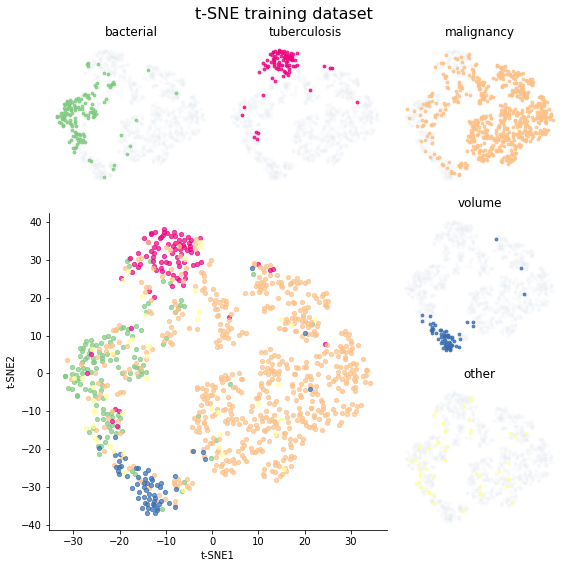

In [35]:
fig2, f2_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f2_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f2_axs[1:, 1]:
    ax.remove()
for ax in f2_axs[1:, 0]:
    ax.remove()
    
axbig = fig2.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig2.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=X_train_l.loc[X_train_l['label']==etiology,"x"].values,
               y=X_train_l.loc[X_train_l['label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f2_axs[0,j].scatter(x=X_train_l.loc[X_train_l['label']==etiology,"x"].values,
                                y=X_train_l.loc[X_train_l['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f2_axs[0,j].set_xticks([])
            f2_axs[0,j].set_yticks([])
            f2_axs[0,j].set_xlabel('')
            f2_axs[0,j].set_ylabel('')
            if idx==j:
                f2_axs[0,j].set_title(f'{etiology}')
            f2_axs[0,j].spines['top'].set_visible(False)
            f2_axs[0,j].spines['right'].set_visible(False)
            f2_axs[0,j].spines['left'].set_visible(False)
            f2_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f2_axs[j-2,2].scatter(x=X_train_l.loc[X_train_l['label']==etiology,"x"].values,
                                y=X_train_l.loc[X_train_l['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f2_axs[j-2,2].set_xticks([])
            f2_axs[j-2,2].set_yticks([])
            f2_axs[j-2,2].set_xlabel('')
            f2_axs[j-2,2].set_ylabel('')
            if idx==j:
                f2_axs[j-2,2].set_title(f'{etiology}')
            f2_axs[j-2,2].spines['left'].set_visible(False)
            f2_axs[j-2,2].spines['right'].set_visible(False)
            f2_axs[j-2,2].spines['bottom'].set_visible(False)
            f2_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig2.tight_layout()
fig2.suptitle("t-SNE training dataset", fontsize=16)
fig2.subplots_adjust(top=0.92)
fig2.savefig("./figures/training_tsne_new 300.png", dpi=300)

### visualization by t-SNE of embedding space in validation set

In [34]:
X_notrain = torch.tensor(np.array(X_notrain), dtype=torch.float32)
y_nottrain = torch.tensor(y_nottrain.numpy().astype(int), dtype=torch.float32)

X_val_data = X_notrain.cuda()
X_validation_graph = tsne.fit_transform(model(X_val_data).cpu().numpy())
y_val_data = y_nottrain.numpy().astype(int)

X_new_l = pd.concat([pd.DataFrame(X_validation_graph),pd.DataFrame(y_val_data, columns=["label"])], axis=1)
X_new_l.label = X_new_l.label.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")
X_new_l = X_new_l.rename(columns={0:"x",
                       1:"y"})

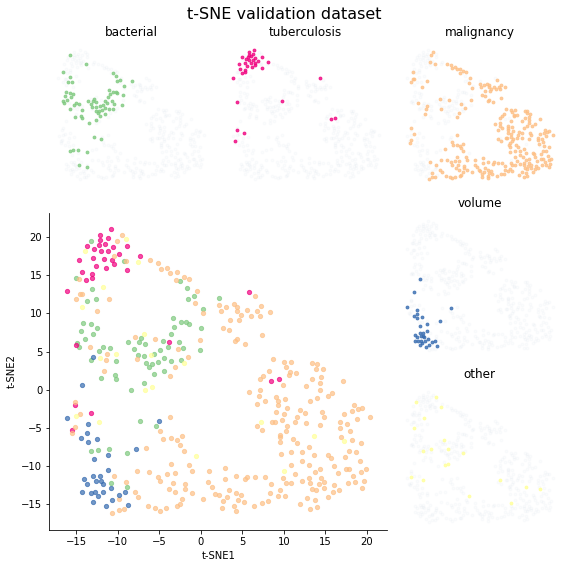

In [36]:
fig3, f3_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f3_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f3_axs[1:, 1]:
    ax.remove()
for ax in f3_axs[1:, 0]:
    ax.remove()
    
axbig = fig3.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig3.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=X_new_l.loc[X_new_l['label']==etiology,"x"].values,
               y=X_new_l.loc[X_new_l['label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f3_axs[0,j].scatter(x=X_new_l.loc[X_new_l['label']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f3_axs[0,j].set_xticks([])
            f3_axs[0,j].set_yticks([])
            f3_axs[0,j].set_xlabel('')
            f3_axs[0,j].set_ylabel('')
            if idx==j:
                f3_axs[0,j].set_title(f'{etiology}')
            f3_axs[0,j].spines['top'].set_visible(False)
            f3_axs[0,j].spines['right'].set_visible(False)
            f3_axs[0,j].spines['left'].set_visible(False)
            f3_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f3_axs[j-2,2].scatter(x=X_new_l.loc[X_new_l['label']==etiology,"x"].values,
                                y=X_new_l.loc[X_new_l['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f3_axs[j-2,2].set_xticks([])
            f3_axs[j-2,2].set_yticks([])
            f3_axs[j-2,2].set_xlabel('')
            f3_axs[j-2,2].set_ylabel('')
            if idx==j:
                f3_axs[j-2,2].set_title(f'{etiology}')
            f3_axs[j-2,2].spines['left'].set_visible(False)
            f3_axs[j-2,2].spines['right'].set_visible(False)
            f3_axs[j-2,2].spines['bottom'].set_visible(False)
            f3_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig3.tight_layout()
fig3.suptitle("t-SNE validation dataset", fontsize=16)
fig3.subplots_adjust(top=0.92)
fig3.savefig("./figures/val_tsne_new 300.png", dpi=300)

### classifier training

In [42]:
add_layer_list = [[5],[128,5],[256,5]]

n_epochs_stop = 20
epoch =5000
min_epoch =100
writer = SummaryWriter('runs/model_classifier')
PATH = './model_classifier0502/'
loss_function = nn.CrossEntropyLoss()

In [45]:
for layer in add_layer_list:
    classifier_ = added_on_model(model_=model, parameter=layer, dimension = 20 )
    classifier_ = classifier_.cuda()        
    optimizer = optim.Adam(classifier_.parameters(), weight_decay = 1e-4, lr=0.0005)
    min_val_loss = np.Inf
    epochs_no_improve = 20
    
    for num_epoch in range(epoch):

        average_loss = 0
        device = 'cuda'
        classifier_ = classifier_.train()
        for batch_idx, (train_X,train_Y) in enumerate(train_loader):
            train_X = train_X.to(device)
            train_Y = torch.tensor(train_Y, dtype=torch.long).to(device)
            output = classifier_(train_X)
            loss = loss_function(output, train_Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            average_loss += loss.item()

        average_loss /=len(train_loader)
        aver_val_loss = 0

        classifier_= classifier_.eval()
        for val_X,val_Y in val_loader:
            val_X = val_X.to(device)
            val_Y = torch.tensor(val_Y, dtype=torch.long).to(device)
            val_output = classifier_(val_X)
            loss_val = loss_function(val_output, val_Y)
            aver_val_loss += loss_val.item()

        aver_val_loss /=len(val_loader)

        writer.add_scalars(f'training_validation_{layer[0]}',
                           {'training':average_loss,
                            'validation':aver_val_loss}, num_epoch)

        if aver_val_loss <= min_val_loss:
            directory = PATH
            #directory 이름은 layer 첫번째 및 두번째 그리고 마지막 layer수 
            if not os.path.exists(directory):
                os.makedirs(directory)
            filename = [f for f in os.listdir(directory) if f.startswith("model_{}".format(layer))]
            if filename:
                if os.path.isfile(directory+filename[0]):
                    os.remove(directory+filename[0])
            torch.save(classifier_, directory+'model_{}_{:.0f}.pt'.format(layer,aver_val_loss*1000))
            epochs_no_improve = 0
            min_val_loss = aver_val_loss
        else:
            epochs_no_improve += 1

        if (num_epoch+1) % 100 == 0:
            print('[layer: %d] %d/%d epoch\t training_Loss = %.6f \t val_loss = %.6f\t min_val_loss = %.6f' %(layer[0], num_epoch+1, epoch,  average_loss, aver_val_loss, min_val_loss))

        # If the validation loss is at a minimum
        if num_epoch > min_epoch and epochs_no_improve == n_epochs_stop:
            print('Early stopping! epoch:{}, min_val_loss:{:.5f}'.format(num_epoch, min_val_loss) )
            early_stop = True
            break
        else:
            continue

[layer: 5] 100/5000 epoch	 training_Loss = 1.476608 	 val_loss = 1.478770	 min_val_loss = 1.469045
[layer: 5] 200/5000 epoch	 training_Loss = 1.341072 	 val_loss = 1.329050	 min_val_loss = 1.329050
[layer: 5] 300/5000 epoch	 training_Loss = 1.230414 	 val_loss = 1.232128	 min_val_loss = 1.209357
[layer: 5] 400/5000 epoch	 training_Loss = 1.137147 	 val_loss = 1.129096	 min_val_loss = 1.104792
Early stopping! epoch:426, min_val_loss:1.10236
[layer: 128] 100/5000 epoch	 training_Loss = 0.754568 	 val_loss = 0.803474	 min_val_loss = 0.758417
Early stopping! epoch:168, min_val_loss:0.58204
[layer: 256] 100/5000 epoch	 training_Loss = 0.667401 	 val_loss = 0.731484	 min_val_loss = 0.581269
Early stopping! epoch:106, min_val_loss:0.58127


In [54]:
classifier_model = torch.load('./model_classifier0502/model_[5]_1102.pt')

X_notrain = torch.tensor(np.array(X_notrain), dtype=torch.float32)
classifier_model = classifier_model.eval()
p_label = classifier_model(X_notrain.cuda())
predict = torch.argmax(p_label, axis=1)

### valioation in training set

In [58]:
# confusion_matrix(y_train, predict.cpu()),
print(confusion_matrix(y_nottrain, predict.cpu()))

#accuracy
print(accuracy_score(y_nottrain, predict.cpu()))
#classification report
print(classification_report(y_nottrain, predict.cpu()))

[[ 49  12   4   3   0]
 [  1  30   2   2   0]
 [ 15  11 221   3   0]
 [  1   0   2  29   0]
 [  5   5   8   1   0]]
0.8143564356435643
              precision    recall  f1-score   support

         0.0       0.69      0.72      0.71        68
         1.0       0.52      0.86      0.65        35
         2.0       0.93      0.88      0.91       250
         3.0       0.76      0.91      0.83        32
         4.0       0.00      0.00      0.00        19

    accuracy                           0.81       404
   macro avg       0.58      0.67      0.62       404
weighted avg       0.80      0.81      0.80       404



In [59]:
acc1, acc2 = accuracy(p_label.cpu(), y_nottrain, topk=(1, 2))
print("top1 accuracy:", acc1.item())
print("top2 accuracy:", acc2.item())

top1 accuracy: 81.4356460571289
top2 accuracy: 90.09900665283203


In [60]:
y_nottrain = torch.tensor(y_nottrain, dtype=torch.long)

one_hot_y = nn.functional.one_hot(y_nottrain)

soft = nn.Softmax(dim=1)
soft(p_label)
soft_x_predict = soft(p_label).cpu().detach().numpy()

In [61]:
print("weighted, ovr", roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'weighted'))
print("macro, ovr ", roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'macro'))
print("micro, ovr" , roc_auc_score(one_hot_y, soft(p_label).cpu().detach().numpy(),  multi_class= 'ovr', average = 'micro'))

weighted, ovr 0.9170441052197834
macro, ovr  0.85696978969666
micro, ovr 0.9332969806881678


#### training data visualization

In [45]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, 
            early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, 
            n_iter_without_progress=300, min_grad_norm=1e-07, 
            metric='euclidean', init='random', verbose=0, 
            random_state=None, method='barnes_hut', angle=0.5)

X_new = tsne.fit_transform(training[col_name].values)
X_whole = pd.concat([pd.DataFrame(X_new),training.iloc[:,-2].reset_index(drop=True)], axis=1)
X_whole = X_whole.rename(columns={0:"x",  1:"y"})

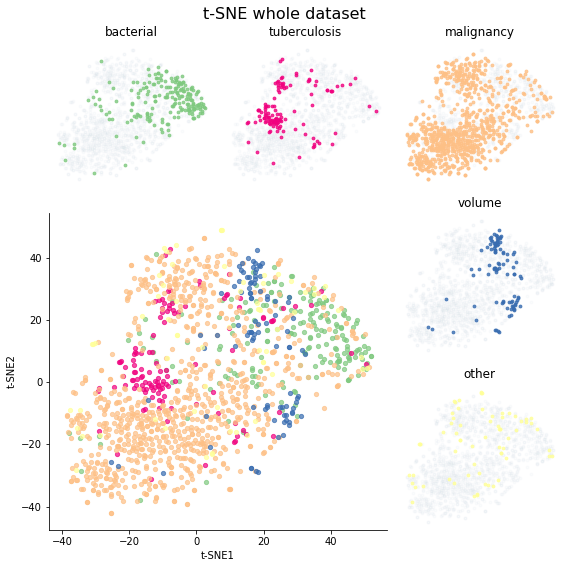

In [46]:
fig4, f4_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f4_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f4_axs[1:, 1]:
    ax.remove()
for ax in f4_axs[1:, 0]:
    ax.remove()
    
axbig = fig4.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig4.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=X_whole.loc[X_whole['new_label']==etiology,"x"].values,
               y=X_whole.loc[X_whole['new_label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('t-SNE1')
    axbig.set_ylabel('t-SNE2')
    for j in range(5):
        if j<2:
            f4_axs[0,j].scatter(x=X_whole.loc[X_whole['new_label']==etiology,"x"].values,
                                y=X_whole.loc[X_whole['new_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f4_axs[0,j].set_xticks([])
            f4_axs[0,j].set_yticks([])
            f4_axs[0,j].set_xlabel('')
            f4_axs[0,j].set_ylabel('')
            if idx==j:
                f4_axs[0,j].set_title(f'{etiology}')
            f4_axs[0,j].spines['top'].set_visible(False)
            f4_axs[0,j].spines['right'].set_visible(False)
            f4_axs[0,j].spines['left'].set_visible(False)
            f4_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f4_axs[j-2,2].scatter(x=X_whole.loc[X_whole['new_label']==etiology,"x"].values,
                                y=X_whole.loc[X_whole['new_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f4_axs[j-2,2].set_xticks([])
            f4_axs[j-2,2].set_yticks([])
            f4_axs[j-2,2].set_xlabel('')
            f4_axs[j-2,2].set_ylabel('')
            if idx==j:
                f4_axs[j-2,2].set_title(f'{etiology}')
            f4_axs[j-2,2].spines['left'].set_visible(False)
            f4_axs[j-2,2].spines['right'].set_visible(False)
            f4_axs[j-2,2].spines['bottom'].set_visible(False)
            f4_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig4.tight_layout()
fig4.suptitle("t-SNE whole dataset", fontsize=16)
fig4.subplots_adjust(top=0.92)
fig4.savefig("./figures/whole_tsne_new 300.png", dpi=300)

#### visualization by UMAP of training set 

In [345]:
from umap import UMAP

umap = UMAP(random_state=0)
dr = umap.fit_transform(training[col_name].values)

umap_l = pd.concat([pd.DataFrame(dr),training.iloc[:,-2].reset_index(drop=True)], axis=1)
umap_l = umap_l.rename(columns={0:"x", 1:"y"})

In [47]:
from umap import UMAP
umap = UMAP(random_state=0, n_neighbors = 50 )
umap.fit(training[col_name].values)
dr = umap.transform(training[col_name].values)

umap_l = pd.concat([pd.DataFrame(dr),training.iloc[:,-2].reset_index(drop=True)], axis=1)
umap_l = umap_l.rename(columns={0:"x", 1:"y"})

In [48]:
colorlist = dict(malignancy=sns.color_palette("Accent",9)[2],
                        volume=sns.color_palette("Accent",9)[4],
                        tuberculosis = sns.color_palette("Accent",9)[5],
                       bacterial = sns.color_palette("Accent",9)[0],
                       other= sns.color_palette("Accent",9)[3],
                       rule_tuberculosis = "#7987FA",
                       not_tuberculosis = "#2F4854",
                       rule_complicated_effusion="#2878EB",
                       not_bacteria = "#3B3A2A")
name = ['other','malignancy','volume','tuberculosis','bacterial']

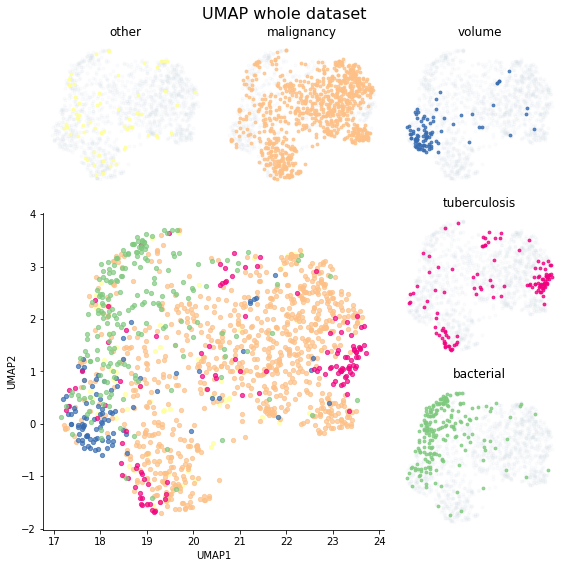

In [49]:
fig7, f7_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f7_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f7_axs[1:, 1]:
    ax.remove()
for ax in f7_axs[1:, 0]:
    ax.remove()
    
axbig = fig7.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig7.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=umap_l.loc[umap_l['new_label']==etiology,"x"].values,
               y=umap_l.loc[umap_l['new_label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f7_axs[0,j].scatter(x=umap_l.loc[umap_l['new_label']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['new_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f7_axs[0,j].set_xticks([])
            f7_axs[0,j].set_yticks([])
            f7_axs[0,j].set_xlabel('')
            f7_axs[0,j].set_ylabel('')
            if idx==j:
                f7_axs[0,j].set_title(f'{etiology}')
            f7_axs[0,j].spines['top'].set_visible(False)
            f7_axs[0,j].spines['right'].set_visible(False)
            f7_axs[0,j].spines['left'].set_visible(False)
            f7_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f7_axs[j-2,2].scatter(x=umap_l.loc[umap_l['new_label']==etiology,"x"].values,
                                y=umap_l.loc[umap_l['new_label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f7_axs[j-2,2].set_xticks([])
            f7_axs[j-2,2].set_yticks([])
            f7_axs[j-2,2].set_xlabel('')
            f7_axs[j-2,2].set_ylabel('')
            if idx==j:
                f7_axs[j-2,2].set_title(f'{etiology}')
            f7_axs[j-2,2].spines['left'].set_visible(False)
            f7_axs[j-2,2].spines['right'].set_visible(False)
            f7_axs[j-2,2].spines['bottom'].set_visible(False)
            f7_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig7.tight_layout()
fig7.suptitle("UMAP whole dataset", fontsize=16)
fig7.subplots_adjust(top=0.92)
fig7.savefig("./figures/whole_umap_new 300.png", dpi=300)

### UMAP visualization of embedding space by constrative-loss model for training set

In [52]:
dr3 = umap.fit_transform(model(X_train.cuda()).cpu().numpy())

y_data = y_train.numpy().astype(int)
y_val_data = y_nottrain.numpy().astype(int)
umap_train = pd.concat([pd.DataFrame(dr3),pd.DataFrame(y_data, columns=["label"])], axis=1)
umap_train = umap_train.rename(columns={0:"x", 1:"y"})
umap_train.label = umap_train.label.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")

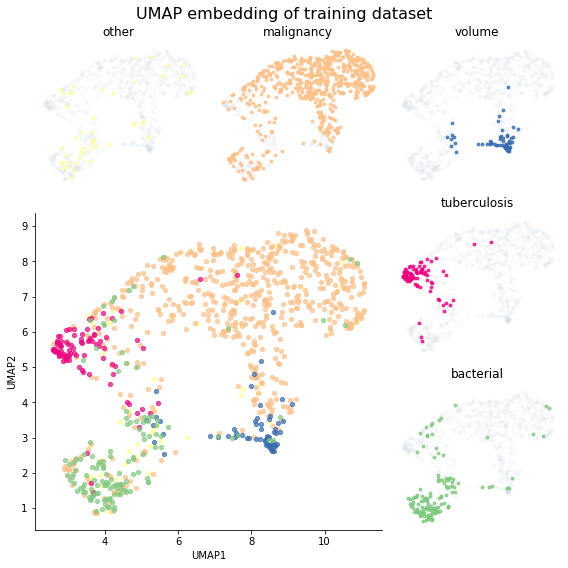

In [53]:
fig2, f2_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f2_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f2_axs[1:, 1]:
    ax.remove()
for ax in f2_axs[1:, 0]:
    ax.remove()
    
axbig = fig2.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig2.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=umap_train.loc[umap_train['label']==etiology,"x"].values,
               y=umap_train.loc[umap_train['label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f2_axs[0,j].scatter(x=umap_train.loc[umap_train['label']==etiology,"x"].values,
                                y=umap_train.loc[umap_train['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f2_axs[0,j].set_xticks([])
            f2_axs[0,j].set_yticks([])
            f2_axs[0,j].set_xlabel('')
            f2_axs[0,j].set_ylabel('')
            if idx==j:
                f2_axs[0,j].set_title(f'{etiology}')
            f2_axs[0,j].spines['top'].set_visible(False)
            f2_axs[0,j].spines['right'].set_visible(False)
            f2_axs[0,j].spines['left'].set_visible(False)
            f2_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f2_axs[j-2,2].scatter(x=umap_train.loc[umap_train['label']==etiology,"x"].values,
                                y=umap_train.loc[umap_train['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f2_axs[j-2,2].set_xticks([])
            f2_axs[j-2,2].set_yticks([])
            f2_axs[j-2,2].set_xlabel('')
            f2_axs[j-2,2].set_ylabel('')
            if idx==j:
                f2_axs[j-2,2].set_title(f'{etiology}')
            f2_axs[j-2,2].spines['left'].set_visible(False)
            f2_axs[j-2,2].spines['right'].set_visible(False)
            f2_axs[j-2,2].spines['bottom'].set_visible(False)
            f2_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig2.tight_layout()
fig2.suptitle("UMAP embedding of training dataset", fontsize=16)
fig2.subplots_adjust(top=0.92)
fig2.savefig("./figures/training_umap_new 300.png", dpi=300)

#### UMAP visualization of embedding space by contrastive model in validation set 

In [50]:
X_notrain = torch.tensor(np.array(X_notrain), dtype=torch.float32)
X_val_data = X_notrain.cuda()
dr2 = umap.fit_transform(model(X_val_data).cpu().numpy())

y_val_data = y_nottrain.numpy().astype(int)
umap_l_val_1 = pd.concat([pd.DataFrame(dr2),pd.DataFrame(y_val_data, columns=["label"])], axis=1)
umap_l_val_1 = umap_l_val_1.rename(columns={0:"x", 1:"y"})
umap_l_val_1.label = umap_l_val_1.label.replace(0,"bacterial").replace(1,"tuberculosis").replace(2,"malignancy").replace(3,"volume").replace(4,"other")

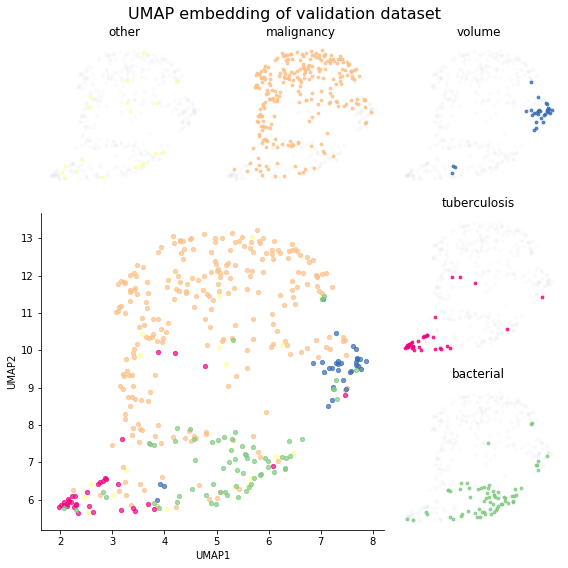

In [51]:
fig1, f1_axs = plt.subplots(ncols=3, nrows=3, figsize=(8,8))
gs = f1_axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in f1_axs[1:, 1]:
    ax.remove()
for ax in f1_axs[1:, 0]:
    ax.remove()
    
axbig = fig1.add_subplot(gs[1:, :2])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')
# fig1.tight_layout()
for idx, etiology in enumerate(name):
    axbig.scatter(x=umap_l_val_1.loc[umap_l_val_1['label']==etiology,"x"].values,
               y=umap_l_val_1.loc[umap_l_val_1['label']==etiology,"y"].values,
              s=18, alpha=0.7, color = colorlist[etiology]
              )
#     axbig.set_xticks([])
#     axbig.set_yticks([])
    axbig.set_xlabel('UMAP1')
    axbig.set_ylabel('UMAP2')
    for j in range(5):
        if j<2:
            f1_axs[0,j].scatter(x=umap_l_val_1.loc[umap_l_val_1['label']==etiology,"x"].values,
                                y=umap_l_val_1.loc[umap_l_val_1['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f1_axs[0,j].set_xticks([])
            f1_axs[0,j].set_yticks([])
            f1_axs[0,j].set_xlabel('')
            f1_axs[0,j].set_ylabel('')
            if idx==j:
                f1_axs[0,j].set_title(f'{etiology}')
            f1_axs[0,j].spines['top'].set_visible(False)
            f1_axs[0,j].spines['right'].set_visible(False)
            f1_axs[0,j].spines['left'].set_visible(False)
            f1_axs[0,j].spines['bottom'].set_visible(False)

          
        else:
            f1_axs[j-2,2].scatter(x=umap_l_val_1.loc[umap_l_val_1['label']==etiology,"x"].values,
                                y=umap_l_val_1.loc[umap_l_val_1['label']==etiology,"y"].values,
                                  s=8, alpha = 0.8 if idx==j else 0.08, color = (colorlist[etiology]) if idx==j else "#CCDAE3",
                                zorder=(idx==j)
                               )
            f1_axs[j-2,2].set_xticks([])
            f1_axs[j-2,2].set_yticks([])
            f1_axs[j-2,2].set_xlabel('')
            f1_axs[j-2,2].set_ylabel('')
            if idx==j:
                f1_axs[j-2,2].set_title(f'{etiology}')
            f1_axs[j-2,2].spines['left'].set_visible(False)
            f1_axs[j-2,2].spines['right'].set_visible(False)
            f1_axs[j-2,2].spines['bottom'].set_visible(False)
            f1_axs[j-2,2].spines['top'].set_visible(False)
            
axbig.spines['right'].set_visible(False)
# axbig.spines['bottom'].set_visible(False)
# axbig.spines['left'].set_visible(False)
axbig.spines['top'].set_visible(False)


fig1.tight_layout()
fig1.suptitle("UMAP embedding of validation dataset", fontsize=16)
fig1.subplots_adjust(top=0.92)
fig1.savefig("./figures/val_umap_new 300.png", dpi=300)